<a href="https://colab.research.google.com/github/chandana-galgali/Text-to-VR-Visualizing-Numerical-Data/blob/main/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder



In [12]:
df = pd.read_excel('/content/Dataset.xlsx')

# New Section

In [13]:

# Function to flatten JSON tables
def flatten_json_table(json_table):
    rows = []
    for row in json_table:
        row_str = ", ".join([f"{k}: {v}" for k, v in row.items()])
        rows.append(row_str)
    return " ; ".join(rows)

# Extract data
flattened_data = []
for i in range(len(df)):
    try:
        table = json.loads(df.loc[i, 'Table'])
        flat_text = flatten_json_table(table)
        label = df.loc[i, 'Visualisation Type']
        flattened_data.append({"input_text": flat_text, "label": label})
    except:
        continue

flattened_df = pd.DataFrame(flattened_data)

# Split and encode
X_train, X_val, y_train, y_val = train_test_split(flattened_df['input_text'], flattened_df['label'], test_size=0.2)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()

X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)

# Classifier model
class ChartTypeClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ChartTypeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = ChartTypeClassifier(X_train_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(15):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        _, preds = torch.max(val_outputs, 1)
        acc = (preds == y_val_tensor).float().mean()
    print(f"Epoch {epoch+1}/15 - Loss: {loss.item():.4f} - Val Acc: {acc.item():.4f}")

# Inference function
def predict_chart_type(json_table):
    text_input = flatten_json_table(json_table)
    vec = vectorizer.transform([text_input]).toarray()
    tensor = torch.tensor(vec, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        pred = torch.argmax(output).item()
        return label_encoder.inverse_transform([pred])[0]

Epoch 1/15 - Loss: 0.6931 - Val Acc: 0.4444
Epoch 2/15 - Loss: 0.6903 - Val Acc: 0.4444
Epoch 3/15 - Loss: 0.6842 - Val Acc: 0.4444
Epoch 4/15 - Loss: 0.6819 - Val Acc: 0.4444
Epoch 5/15 - Loss: 0.6769 - Val Acc: 0.5556
Epoch 6/15 - Loss: 0.6713 - Val Acc: 0.5556
Epoch 7/15 - Loss: 0.6679 - Val Acc: 0.5556
Epoch 8/15 - Loss: 0.6623 - Val Acc: 0.6667
Epoch 9/15 - Loss: 0.6577 - Val Acc: 0.7778
Epoch 10/15 - Loss: 0.6532 - Val Acc: 0.7778
Epoch 11/15 - Loss: 0.6436 - Val Acc: 0.7778
Epoch 12/15 - Loss: 0.6374 - Val Acc: 0.8889
Epoch 13/15 - Loss: 0.6349 - Val Acc: 0.8889
Epoch 14/15 - Loss: 0.6258 - Val Acc: 0.8889
Epoch 15/15 - Loss: 0.6168 - Val Acc: 0.8889


Predicted chart type: Line


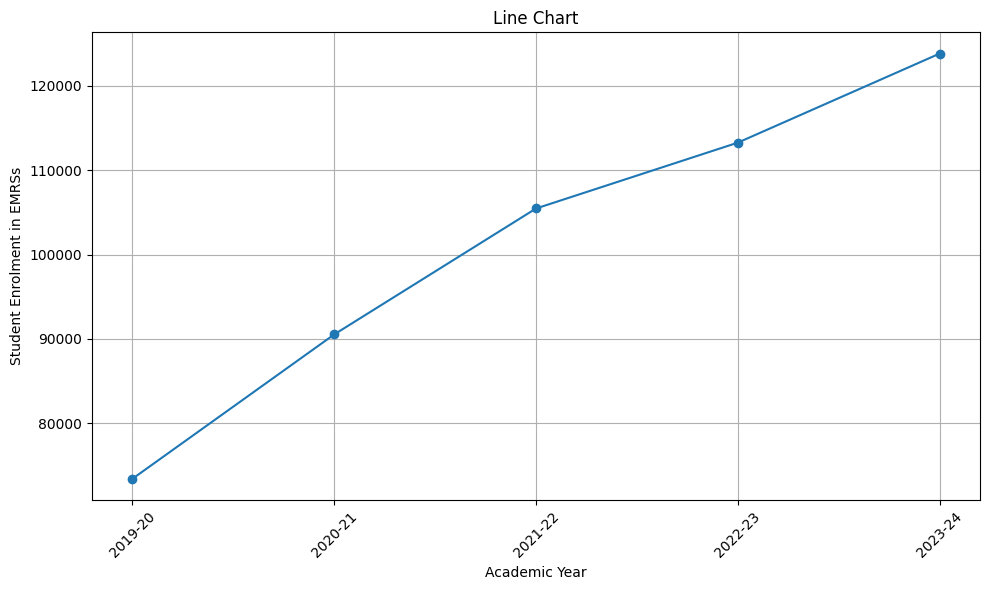

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Use this only after loading and training the model, vectorizer, label_encoder

# Step 1: Flatten JSON Table
def flatten_json_table(json_table):
    rows = []
    for row in json_table:
        row_str = ", ".join([f"{k}: {v}" for k, v in row.items()])
        rows.append(row_str)
    return " ; ".join(rows)

# Step 2: Predict Chart Type
def predict_chart_type(json_table):
    text_input = flatten_json_table(json_table)
    vec = vectorizer.transform([text_input]).toarray()
    tensor = torch.tensor(vec, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        pred = torch.argmax(output).item()
        return label_encoder.inverse_transform([pred])[0]

# Step 3: Draw Chart
def draw_chart_from_json(json_table, chart_type):
    df = pd.DataFrame(json_table)
    if len(df.columns) < 2:
        print("Not enough columns to plot.")
        return

    x = df.columns[0]
    y = df.columns[1]

    plt.figure(figsize=(10, 6))
    if chart_type.lower() == "line":
        plt.plot(df[x], df[y], marker="o")
        plt.title("Line Chart")
    elif chart_type.lower() == "bar":
        plt.bar(df[x], df[y])
        plt.title("Bar Chart")
    else:
        print("Unknown chart type.")
        return

    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Step 4: Try It Out
example_input = [
        {
        "Academic Year": "2019-20",
        "Student Enrolment in EMRSs": 73391
    },
    {
        "Academic Year": "2020-21",
        "Student Enrolment in EMRSs": 90520
    },
    {
        "Academic Year": "2021-22",
        "Student Enrolment in EMRSs": 105463
    },
    {
        "Academic Year": "2022-23",
        "Student Enrolment in EMRSs": 113275
    },
    {
        "Academic Year": "2023-24",
        "Student Enrolment in EMRSs": 123841
    }
]

predicted_type = predict_chart_type(example_input)
print("Predicted chart type:", predicted_type)
draw_chart_from_json(example_input, predicted_type)


Predicted chart type: Bar


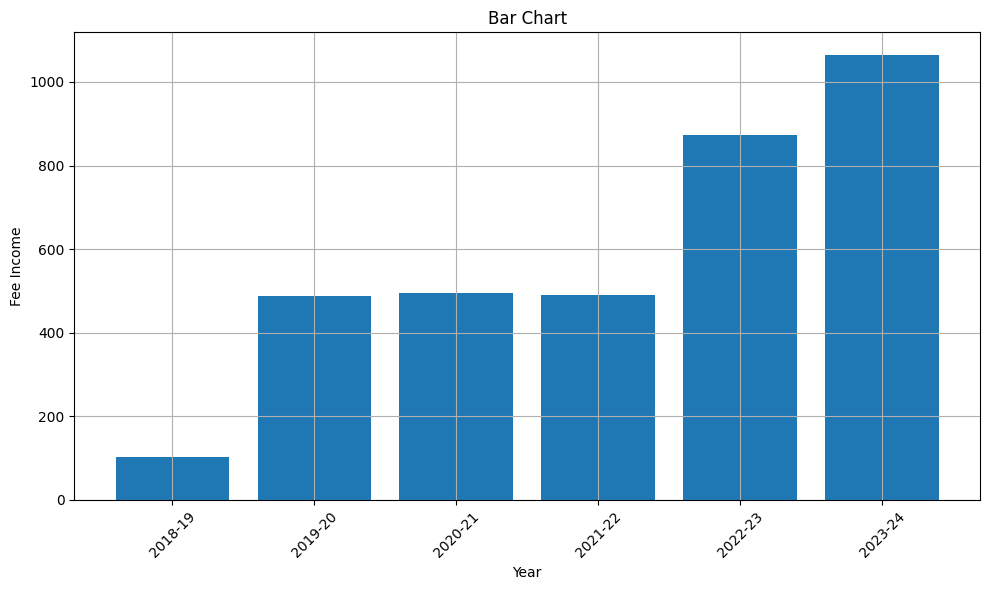

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Use this only after loading and training the model, vectorizer, label_encoder

# Step 1: Flatten JSON Table
def flatten_json_table(json_table):
    rows = []
    for row in json_table:
        row_str = ", ".join([f"{k}: {v}" for k, v in row.items()])
        rows.append(row_str)
    return " ; ".join(rows)

# Step 2: Predict Chart Type
def predict_chart_type(json_table):
    text_input = flatten_json_table(json_table)
    vec = vectorizer.transform([text_input]).toarray()
    tensor = torch.tensor(vec, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        pred = torch.argmax(output).item()
        return label_encoder.inverse_transform([pred])[0]

# Step 3: Draw Chart
def draw_chart_from_json(json_table, chart_type):
    df = pd.DataFrame(json_table)
    if len(df.columns) < 2:
        print("Not enough columns to plot.")
        return

    x = df.columns[0]
    y = df.columns[1]

    plt.figure(figsize=(10, 6))
    if chart_type.lower() == "line":
        plt.plot(df[x], df[y], marker="o")
        plt.title("Line Chart")
    elif chart_type.lower() == "bar":
        plt.bar(df[x], df[y])
        plt.title("Bar Chart")
    else:
        print("Unknown chart type.")
        return

    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Step 4: Try It Out
example_input = [
    {
        "Year": "2018-19",
        "Fee Income": 101.51,
        "Total Expenditure": 118.43
    },
    {
        "Year": "2019-20",
        "Fee Income": 488.08,
        "Total Expenditure": 390.01
    },
    {
        "Year": "2020-21",
        "Fee Income": 494.46,
        "Total Expenditure": 427.94
    },
    {
        "Year": "2021-22",
        "Fee Income": 490.35,
        "Total Expenditure": 426.52
    },
    {
        "Year": "2022-23",
        "Fee Income": 873.2,
        "Total Expenditure": 681.52
    },
    {
        "Year": "2023-24",
        "Fee Income": 1065.38,
        "Total Expenditure": 1020.35
    }
]

predicted_type = predict_chart_type(example_input)
print("Predicted chart type:", predicted_type)
draw_chart_from_json(example_input, predicted_type)


Predicted chart type: Bar


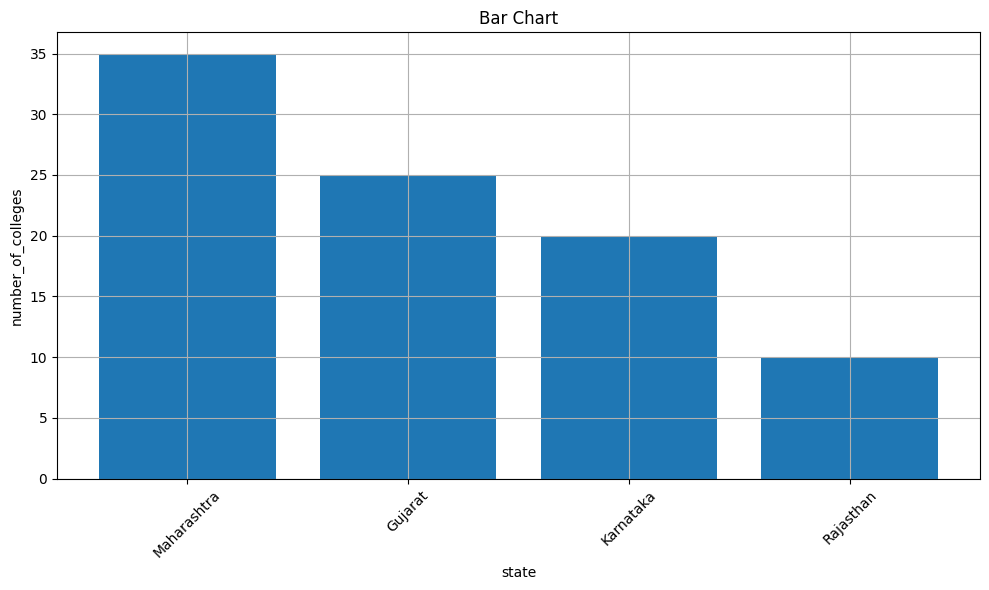

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Use this only after loading and training the model, vectorizer, label_encoder

# Step 1: Flatten JSON Table
def flatten_json_table(json_table):
    rows = []
    for row in json_table:
        row_str = ", ".join([f"{k}: {v}" for k, v in row.items()])
        rows.append(row_str)
    return " ; ".join(rows)

# Step 2: Predict Chart Type
def predict_chart_type(json_table):
    text_input = flatten_json_table(json_table)
    vec = vectorizer.transform([text_input]).toarray()
    tensor = torch.tensor(vec, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        pred = torch.argmax(output).item()
        return label_encoder.inverse_transform([pred])[0]

# Step 3: Draw Chart
def draw_chart_from_json(json_table, chart_type):
    df = pd.DataFrame(json_table)
    if len(df.columns) < 2:
        print("Not enough columns to plot.")
        return

    x = df.columns[0]
    y = df.columns[1]

    plt.figure(figsize=(10, 6))
    if chart_type.lower() == "line":
        plt.plot(df[x], df[y], marker="o")
        plt.title("Line Chart")
    elif chart_type.lower() == "bar":
        plt.bar(df[x], df[y])
        plt.title("Bar Chart")
    else:
        print("Unknown chart type.")
        return

    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Step 4: Try It Out
example_input =[
    {
      "state": "Maharashtra",
      "number_of_colleges": 35
    },
    {
      "state": "Gujarat",
      "number_of_colleges": 25
    },
    {
      "state": "Karnataka",
      "number_of_colleges": 20
    },
    {
      "state": "Rajasthan",
      "number_of_colleges": 10
    }
  ]

predicted_type = predict_chart_type(example_input)
print("Predicted chart type:", predicted_type)
draw_chart_from_json(example_input, predicted_type)


Please enter the JSON table (e.g. [{'Year': '2020', 'Value': 100}, ...]): [     {       "state": "Maharashtra",       "number_of_colleges": 35     },     {       "state": "Gujarat",       "number_of_colleges": 25     },     {       "state": "Karnataka",       "number_of_colleges": 20     },     {       "state": "Rajasthan",       "number_of_colleges": 10     }   ]
Predicted chart type: Bar


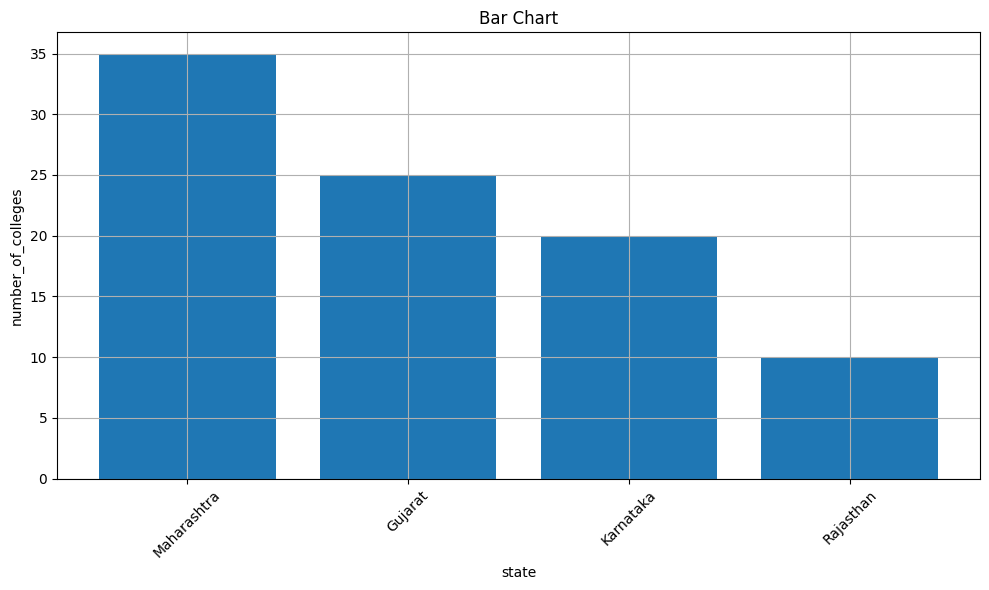

In [23]:
import json
import matplotlib.pyplot as plt
import torch

# Function to flatten JSON input
def flatten_json_table(json_table):
    rows = []
    for row in json_table:
        row_str = ", ".join([f"{k}: {v}" for k, v in row.items()])
        rows.append(row_str)
    return " ; ".join(rows)

# Function to predict chart type
def predict_chart_type(json_table):
    text_input = flatten_json_table(json_table)
    vec = vectorizer.transform([text_input]).toarray()  # Use pre-trained vectorizer
    tensor = torch.tensor(vec, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        pred = torch.argmax(output).item()
        return label_encoder.inverse_transform([pred])[0]

# Function to generate chart
def draw_chart_from_json(json_table, chart_type):
    df = pd.DataFrame(json_table)
    if len(df.columns) < 2:
        print("Not enough columns to plot.")
        return

    x = df.columns[0]
    y = df.columns[1]

    plt.figure(figsize=(10, 6))
    if chart_type.lower() == "line":
        plt.plot(df[x], df[y], marker="o")
        plt.title("Line Chart")
    elif chart_type.lower() == "bar":
        plt.bar(df[x], df[y])
        plt.title("Bar Chart")
    else:
        print("Unknown chart type.")
        return

    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Step 1: Take user input for the JSON table
user_input = input("Please enter the JSON table (e.g. [{'Year': '2020', 'Value': 100}, ...]): ")

# Step 2: Parse the user input (JSON format)
try:
    user_json = json.loads(user_input)
except json.JSONDecodeError:
    print("Invalid JSON format. Please ensure your input is correct.")
    exit()

# Step 3: Predict chart type
predicted_type = predict_chart_type(user_json)
print(f"Predicted chart type: {predicted_type}")

# Step 4: Generate chart
draw_chart_from_json(user_json, predicted_type)
